------------------------------------------------------------------------
<center>

# Modeling:

## Bank Marketing
</center>

*Discentes:*

    *   Arthur Bezerra Calado
    *   Gabriel D'assumpção de Carvalho
    *   Pedro Henrique Sarmento de Paula

*Data:* 01/08/2024

------------------------------------------------------------------------

------------------------------------------------------------------------

## Introdução

Depois do entendimento do negócio, entendimento dos dados e preparação dos dados, esta parte do projeto consiste na estruturação dos modelos de classificação que têm como objetivo identificar clientes mais propensos a fazer um depósito a prazo nas próximas campanhas de telemarketing do banco. Os modelos a serem criados são:

- K-NN (K-Nearest Neighbors)
- LVQ (Learning Vector Quantization)
- Árvore de Decisão (Decision Tree)
- SVM (Support Vector Machine)
- Floresta Aleatória (Random Forest)
- Rede Neural MLP (Multi-Layer Perceptron)
- Comitê de Redes Neurais Artificiais (Ensemble of Artificial Neural Networks)
- Comitê Heterogêneo (Heterogeneous Ensemble)

Devido ao desbalanceamento de algumas classes no banco de dados analisado, os modelos utilizarão os dados divididos em três subconjuntos: treinamento, validação e teste. Utilizamos a função `train_test_split` da biblioteca Scikit-learn para realizar essa divisão, alocando 80% dos dados para os conjuntos de treinamento e validação, e 20% para o conjunto de teste, que foi mantido separado para a avaliação final. Dentro dos 80% destinados ao treinamento e validação, dividimos novamente para obter 75% para o treinamento e 25% para a validação. Utilizamos o parâmetro `stratify` para garantir que a proporção das classes da variável target fosse mantida em todos os subconjuntos, assegurando uma representatividade consistente.

Após o treinamento, validação e teste dos modelos, serão propostas as seguintes métricas para a avaliação dos modelos:

- Acurácia
- F1-Score
- Curva ROC
- Recall

Com base nessas métricas, serão criados gráficos para comparar o desempenho de cada modelo e facilitar na decisão de escolha para a seleção do modelo final.

# Bibliotecas Utilizadas

1. **Pandas**: Manipulação e análise de dados.
2. **NumPy**: Cálculos estatísticos e operações com arrays.
3. **Matplotlib**: Criação de gráficos e visualizações.
4. **Seaborn**: Visualização de dados baseada em Matplotlib, com foco em gráficos estatísticos.
5. **SciPy**: Transformação de variáveis e funções estatísticas avançadas.
6. **Warnings**: Remoção e controle de avisos desnecessários.
7. **Scikit-learn (sklearn)**: Implementação de modelos de machine learning e deep learning.
8. **Imblearn**: Para balanceamento de classes

In [96]:
# Instalação das bibliotecas

# !pip3 install pandas
# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install scipy
# !pip3 install scikit-learn
# !pip3 install imblearn

In [1]:
# Importação das Bibliotecas

## Manipulação de Dados
import pandas as pd
import numpy as np

## Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

## Controle de Avisos
import warnings
warnings.filterwarnings('ignore')

## Exibição no IPython
from IPython.display import display, Markdown

## Modelagem e Avaliação
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from math import ceil

## Modelos
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Estatísticas
from scipy.stats import randint

## Visualização de Árvore
from IPython.display import Image

# Importação dos dados

Os dados que estamos importando correspondem à versão transformada na terceira etapa do projeto. Para acessar a base original, [clique aqui](https://archive.ics.uci.edu/dataset/222/bank+marketing). A nossa versão da base passou por uma série de processos metodológicos, incluindo a melhoria da distribuição dos dados numéricos, a imputação de valores ausentes e a transformação das variáveis categóricas. Esses ajustes foram realizados com o objetivo de otimizar a qualidade dos dados e facilitar as análises subsequentes.

In [2]:
# Importação dos features (X) e target (y)
X = pd.read_pickle('https://github.com/gabrieldadcarvalho/machine_learning/raw/main/pjt_final/data/Xt.pkl')
y = pd.read_pickle('https://github.com/gabrieldadcarvalho/machine_learning/raw/main/pjt_final/data/y.pkl')
X.head()

,age,balance,day_of_week,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0.757508,0.734147,5,0.593557,1,-1,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,0.562668,0.130626,5,0.462402,1,-1,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0.351498,0.000000,5,0.316917,1,-1,0,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.609861,0.669555,5,0.355418,1,-1,0,True,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0.351498,0.000000,5,0.525555,1,-1,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False


# Criação das amostras do dataset para os classificadores

Como mencionado na seção de entendimento do negócio, a criação de modelos de aprendizado de máquina para grandes volumes de dados exige uma capacidade computacional significativa. No entanto, devido às limitações do hardware disponível, que consiste em um notebook online da Deepnote com 2 vCPUs e 5 GB de memória RAM, vamos utilizar apenas 5% da base de dados para a construção dos nossos modelos. Essa abordagem visa otimizar o desempenho e garantir a viabilidade das análises dentro das restrições de hardware impostas.

In [99]:
X_sample = X.sample(frac=1, random_state=1)
y_sample = y.loc[X_sample.index]

# Separação Dados Teste, Vadaliação e Treinamento

In [100]:
# Construindo conjuntos de treinamento, validação e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

# Balanceamento do dataset utilizando SMOTE
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Inicializar uma lista para armazenar os resultados de cada classificador
results = []

# K-NN

O algoritmo K-Nearest Neighbors (K-NN) é amplamente utilizado em tarefas de classificação e regressão no campo de machine learning. O conceito central do K-NN é classificar um dado com base na similaridade com os seus vizinhos mais próximos no espaço de características. Para determinar a classe ou o valor de um ponto de dados, o K-NN calcula a distância entre o ponto a ser classificado e os pontos no conjunto de treinamento. A decisão final é baseada nas classes ou valores dos K vizinhos mais próximos, onde K é um parâmetro definido pelo usuário. O K-NN é simples de entender e implementar, e não requer um treinamento explícito, mas pode ser computacionalmente intensivo e sensível à escala dos dados, além de exigir a escolha apropriada de K para evitar problemas como o sobreajuste.

## Treinando o classificador

In [101]:
# Inicializar listas para armazenar acurácia e melhores k
accuracy_scores = []
best_k = 0
max_accuracy = 0

# Iterar sobre a faixa de 1 a 50
for i in range(1, 51):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    knn_accuracy = knn.score(X_train, y_train)
    accuracy_scores.append(knn_accuracy)
    # Verificar se a acurácia atual é a maior
    if knn_accuracy > max_accuracy:
        max_accuracy = knn_accuracy
        best_k = i
print(f"Algoritmo kNN com {best_k} vizinhos teve a melhor accuracy de {max_accuracy * 100:.2f}%")


Algoritmo kNN com 1 vizinhos teve a melhor accuracy de 100.00%


## Apresentando os resultados

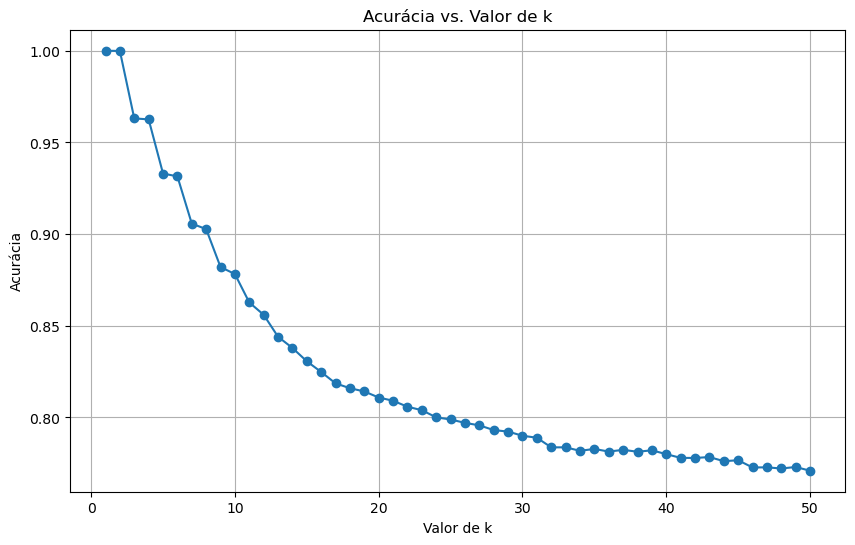

Algoritmo kNN com 1 vizinhos teve a melhor accuracy de 100.00%


In [102]:
# Plotar os resultados
plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), accuracy_scores, marker='o')
plt.title('Acurácia vs. Valor de k')
plt.xlabel('Valor de k')
plt.ylabel('Acurácia')
plt.grid()
plt.show()

print(f"Algoritmo kNN com {best_k} vizinhos teve a melhor accuracy de {max_accuracy * 100:.2f}%")

In [103]:
# Treinar o modelo com o melhor k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = best_knn.predict(X_test)

# Calcular as métricas de desempenho
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Exibir os resultados
print(f"Melhor k: {best_k}")
print(f"Acurácia no conjunto de teste: {test_accuracy * 100:.2f}%")
print(f"Precisão: {test_precision * 100:.2f}%")
print(f"Recall: {test_recall * 100:.2f}%")
print(f"F1 Score: {test_f1 * 100:.2f}%")

Melhor k: 1
Acurácia no conjunto de teste: 85.43%
Precisão: 84.62%
Recall: 85.43%
F1 Score: 85.00%


# LVQ (Learning Vector Quantization) 

O Learning Vector Quantization (LVQ) é uma técnica de aprendizado supervisionado usada para classificação, inspirada nos princípios de redes neurais e técnicas de quantização vetorial. O LVQ funciona ajustando um conjunto de vetores de referência (ou protótipos) para representar as diferentes classes presentes nos dados de treinamento. Cada vetor de referência está associado a uma classe específica e é ajustado iterativamente para melhorar a precisão da classificação. O algoritmo atribui um ponto de dados à classe do vetor de referência mais próximo, calculado com base em uma métrica de distância. A atualização dos vetores de referência é realizada para minimizar a distância entre os vetores e os dados pertencentes à mesma classe, e maximizar a distância entre os vetores e os dados de classes diferentes. Embora o LVQ possa ser eficaz para certos problemas de classificação, ele pode ser sensível à escolha dos vetores de referência iniciais e ao número de protótipos utilizados.


## Treinando o classificador

## Apresentando os resultados

# Árvore de Decisão (Decision Tree)

As Árvores de Decisão são modelos de machine learning utilizados para tarefas de classificação e regressão. Elas funcionam dividindo os dados de entrada em subconjuntos mais homogêneos com base em um conjunto de regras de decisão derivadas dos atributos dos dados. Cada nó interno representa uma pergunta sobre um atributo, cada ramo representa o resultado da pergunta e cada folha representa uma classe ou valor de saída. A construção de uma Árvore de Decisão envolve a seleção do melhor atributo para dividir os dados em cada nó, geralmente utilizando métricas como entropia, ganho de informação ou índice Gini. As Árvores de Decisão são fáceis de interpretar e entender, mas podem sofrer de sobreajuste, especialmente com dados ruidosos.

## Treinando o classificador

In [104]:
# Espaço de busca de hiperparâmetros
max_depth_range = [3, 5, 7, 10, 15, 20, 30, None]
criterion_range = ['gini', 'entropy']

# Listas para armazenar as métricas
dt_scores_train = []
dt_scores_valid = []
dt_scores_cross = []
dt_precisions = []
dt_recalls = []
dt_f1s = []
dt_aucs = []

# Iteração para encontrar as melhores configurações
for depth in max_depth_range:
    for criterion in criterion_range:
        dt = DecisionTreeClassifier(max_depth=depth, criterion=criterion)
        scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        dt_scores_cross.append(scores.mean())
        dt.fit(X_train, y_train)
        
        # Previsões
        y_train_pred = dt.predict(X_train)
        y_valid_pred = dt.predict(X_valid)
        y_valid_prob = dt.predict_proba(X_valid)[:, 1]
        
        # Armazenando as métricas
        dt_scores_train.append(dt.score(X_train, y_train))
        dt_scores_valid.append(dt.score(X_valid, y_valid))
        dt_precisions.append(precision_score(y_valid, y_valid_pred, pos_label=1))
        dt_recalls.append(recall_score(y_valid, y_valid_pred, pos_label=1))
        dt_f1s.append(f1_score(y_valid, y_valid_pred, pos_label=1))
        dt_aucs.append(roc_auc_score(y_valid, y_valid_prob))

# Encontrando a melhor configuração testada
the_best_acc = dt_scores_cross.index(max(dt_scores_cross))
the_best_depth = ceil(the_best_acc / len(criterion_range)) - 1
the_best_criterion = the_best_acc % len(criterion_range)
st_out = ("Max Depth: " + str(max_depth_range[the_best_depth]) + " \nAcurácia: " +
          str(round(dt_scores_cross[the_best_acc], 3)) + "\nCriterion: " + str(criterion_range[the_best_criterion]))

## Apresentando os resultados

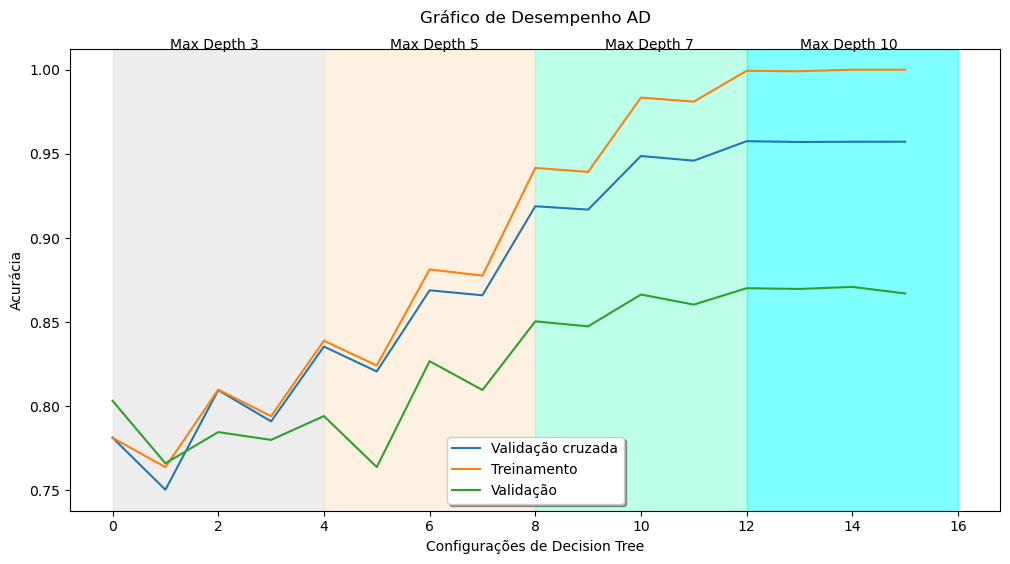

Desempenho da melhor configuração testada:
Max Depth: 20
Criterion: gini
Acurácia de treinamento clf: 0.984
Acurácia de validação clf: 0.869
Acurácia de teste clf: 0.861
Precision clf: 0.420
Recall clf: 0.510
F1 clf: 0.460
AUC-ROC clf: 0.711


In [105]:
# Ajustando o tamanho do gráfico
plt.figure(figsize=(12, 6))
# Apresentando todas as configurações testadas
plt.plot(list(range(0, len(dt_scores_cross))), dt_scores_cross)
plt.plot(list(range(0, len(dt_scores_train))), dt_scores_train)
plt.plot(list(range(0, len(dt_scores_valid))), dt_scores_valid)
plt.axvspan(0, 2*len(criterion_range), color='gainsboro', alpha=0.5)
plt.axvspan(2*len(criterion_range), 4*len(criterion_range), color='bisque', alpha=0.5)
plt.axvspan(4*len(criterion_range), 6*len(criterion_range), color='aquamarine', alpha=0.5)
plt.axvspan(6*len(criterion_range), 8*len(criterion_range), color='cyan', alpha=0.5)
plt.annotate('Max Depth 3', xy=(170, 515), xycoords='figure pixels')
plt.annotate('Max Depth 5', xy=(390, 515), xycoords='figure pixels')
plt.annotate('Max Depth 7', xy=(605, 515), xycoords='figure pixels')
plt.annotate('Max Depth 10', xy=(800, 515), xycoords='figure pixels')
# plt.annotate(st_out, xy=(720, 460), xycoords='figure pixels', xytext=(-40, -70), textcoords='offset points',
#         arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-95"))

plt.legend(('Validação cruzada', 'Treinamento', 'Validação'), loc='lower center', shadow=True)
plt.xlabel('Configurações de Decision Tree')
plt.ylabel('Acurácia')
plt.title('Gráfico de Desempenho AD\n')
plt.show()

# Desempenho da melhor configuração
clf = DecisionTreeClassifier(max_depth=max_depth_range[the_best_depth], criterion=criterion_range[the_best_criterion], random_state=10)
clf.fit(X_train, y_train)
print("Desempenho da melhor configuração testada:")
print("Max Depth: %s" % max_depth_range[the_best_depth])
print("Criterion: %s" % criterion_range[the_best_criterion])
print("Acurácia de treinamento clf: %0.3f" % clf.score(X_train, y_train))
print("Acurácia de validação clf: %0.3f" % clf.score(X_valid, y_valid))
print("Acurácia de teste clf: %0.3f" % clf.score(X_test, y_test))
print("Precision clf: %0.3f" % precision_score(y_test, clf.predict(X_test), pos_label=1))
print("Recall clf: %0.3f" % recall_score(y_test, clf.predict(X_test), pos_label=1))
print("F1 clf: %0.3f" % f1_score(y_test, clf.predict(X_test), pos_label=1))
print("AUC-ROC clf: %0.3f" % roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Definir um dicionário para armazenar os resultados atuais
current_results_decision_tree = {
    "Classificador": "AD",
    "Max Depth": max_depth_range[the_best_depth],
    "Criterion": criterion_range[the_best_criterion],
    "Acurácia de Treinamento": clf.score(X_train, y_train),
    "Acurácia de Validação": clf.score(X_valid, y_valid),
    "Acurácia de Teste": clf.score(X_test, y_test),
    "Precision": precision_score(y_test, clf.predict(X_test), pos_label=1),
    "Recall": recall_score(y_test, clf.predict(X_test), pos_label=1),
    "F1": f1_score(y_test, clf.predict(X_test), pos_label=1),
    "AUC-ROC": roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
}

# Adicionar os resultados do DT à lista de resultados
results.append(current_results_decision_tree)

# SVM (Support Vector Machine)

Os Support Vector Machines são modelos supervisionados de aprendizado de máquina usados principalmente para tarefas de classificação, embora também possam ser aplicadas a problemas de regressão. A ideia central do SVM é encontrar um hiperplano em um espaço de alta dimensão que separa os dados em diferentes classes com a maior margem possível. Esse hiperplano é definido pelos vetores de suporte, que são os pontos de dados mais próximos do hiperplano. SVMs podem utilizar diferentes funções de kernel (linear, polinomial, radial, etc.) para lidar com dados que não são linearmente separáveis. Elas são eficazes em espaços de alta dimensão e em casos onde a relação entre as características não é linear.

## Treinando o classificador

In [106]:
#criando o classificador
clf = SVC()

#treinando o classificador com a funcao fit
clf.fit(X_train, y_train)

SVC()

In [107]:
# Construindo o espaço de busca por configurações do classificador
kernels_range = ['linear', 'poly', 'rbf', 'sigmoid']
c_range = [0.1, 1, 2, 4, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]
gamma_ = [1, 3, 4, 5, 7, 10, 15, 20, 25, 30, 40, 50, 100, 200, 500, 1000]

# c_range = [0.01, 0.1, 1, 10, 100, 1000]  # Reduzido para valores mais espaçados
# gamma_range = [0.001, 0.01, 0.1, 1, 10, 100]  # Reduzido para valores mais espaçados


# Listas para armazenar as métricas
k_scores_train = []
k_scores_valid = []
k_scores_cross = []
k_precisions = []
k_recalls = []
k_f1s = []
k_aucs = []

# Use iteration to calculate different kernels in models,
# then return the average accuracy based on the cross validation
for j in range(len(kernels_range)):
    for k in c_range:
        if kernels_range[j] == 'linear':
            svc = LinearSVC(C=k, random_state=10)
            svc = CalibratedClassifierCV(svc)  # Calibra o LinearSVC para obter probabilidades
        else:
            svc = SVC(C=k, kernel=kernels_range[j], probability=True, random_state=10)  # Adiciona probability=True para calcular AUC-ROC
        scores = cross_val_score(svc, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        k_scores_cross.append(scores.mean())
        svc.fit(X_train, y_train)
        
        # Previsões
        y_train_pred = svc.predict(X_train)
        y_valid_pred = svc.predict(X_valid)
        y_valid_prob = svc.predict_proba(X_valid)[:, 1]
        
        # Armazenando as métricas
        k_scores_train.append(svc.score(X_train, y_train))
        k_scores_valid.append(svc.score(X_valid, y_valid))
        k_precisions.append(precision_score(y_valid, y_valid_pred, pos_label=1))
        k_recalls.append(recall_score(y_valid, y_valid_pred, pos_label=1))
        k_f1s.append(f1_score(y_valid, y_valid_pred, pos_label=1))
        k_aucs.append(roc_auc_score(y_valid, y_valid_prob))

# Encontrando a melhor configuração testada
the_best_acc = k_scores_cross.index(max(k_scores_cross))
the_best_kernel = ceil(the_best_acc / len(c_range)) - 1
the_best_c = the_best_acc / len(c_range)
the_best_c = (the_best_c - int(the_best_c)) * len(c_range)
st_out = ("Kernel: " + str(kernels_range[the_best_kernel]) + " \nAcurácia: " +
          str(round(k_scores_cross[the_best_acc], 3)) + "\nC: " + str(c_range[int(the_best_c)]))


/home/gabrieldadcarvalho/anaconda3/envs/am/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gabrieldadcarvalho/anaconda3/envs/am/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gabrieldadcarvalho/anaconda3/envs/am/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gabrieldadcarvalho/anaconda3/envs/am/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataC

## Apresentando os resultados

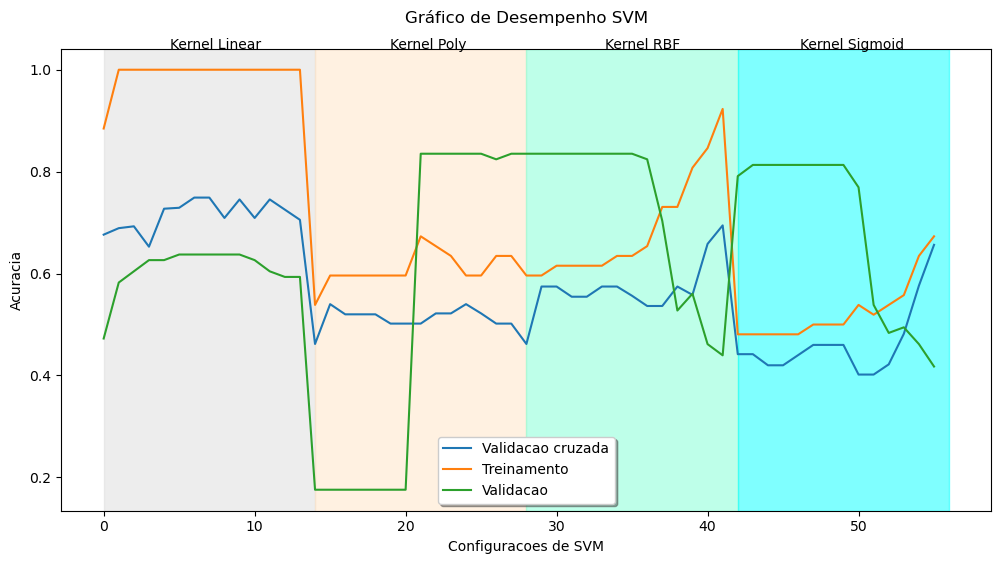

Desempenho da melhor configuracao testada:
Kernel: linear
Acuracia de treinamento clf: 1.0000
Acuracia de validacao clf: 0.6374
Acuracia de teste clf: 0.5275
Precision clf: 0.0889
Recall clf: 0.6667
F1 clf: 0.1569
AUC-ROC clf: 0.7039


In [ ]:
# Ajustando o tamanho do gráfico
plt.figure(figsize=(12, 6))
# Apresentando todas as configuracoes testadas
plt.plot(list(range(0,len(k_scores_cross))), k_scores_cross)
plt.plot(list(range(0,len(k_scores_train))), k_scores_train)
plt.plot(list(range(0,len(k_scores_valid))), k_scores_valid)
plt.axvspan(0, len(c_range), color='gainsboro', alpha=0.5)
plt.axvspan(len(c_range), 2*len(c_range), color='bisque', alpha=0.5)
plt.axvspan(2*len(c_range), 3*len(c_range), color='aquamarine', alpha=0.5)
plt.axvspan(3*len(c_range), 4*len(c_range), color='cyan', alpha=0.5)
plt.annotate('Kernel Linear',xy=(170, 515), xycoords='figure pixels')
plt.annotate('Kernel Poly',xy=(390, 515), xycoords='figure pixels')
plt.annotate('Kernel RBF',xy=(605, 515), xycoords='figure pixels')
plt.annotate('Kernel Sigmoid',xy=(800, 515), xycoords='figure pixels')
# plt.annotate(st_out, xy=(720, 460), xycoords='figure pixels',xytext=(-40, -70), textcoords='offset points',
#         arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-95"))

plt.legend(('Validacao cruzada', 'Treinamento', 'Validacao'),
           loc='lower center', shadow=True)
plt.xlabel('Configuracoes de SVM')
plt.ylabel('Acuracia')
plt.title('Gráfico de Desempenho SVM\n')
plt.show()

#desempenho da melhor configuracao
clf = SVC(C=c_range[int(the_best_c)], kernel=kernels_range[the_best_kernel], random_state=10)
clf = CalibratedClassifierCV(clf)
#treinando o classificador com a funcao fit
clf.fit(X_train, y_train)
print("Desempenho da melhor configuracao testada:")
print("Kernel: %s" %  kernels_range[the_best_kernel])
print("Acuracia de treinamento clf: %0.4f" %  clf.score(X_train, y_train))
print("Acuracia de validacao clf: %0.4f" %  clf.score(X_valid, y_valid))
print("Acuracia de teste clf: %0.4f" %  clf.score(X_test, y_test))
print("Precision clf: %0.4f" %  precision_score(y_test, clf.predict(X_test), pos_label=1))
print("Recall clf: %0.4f" %  recall_score(y_test, clf.predict(X_test), pos_label=1))
print("F1 clf: %0.4f" %  f1_score(y_test, clf.predict(X_test), pos_label=1))
print("AUC-ROC clf: %0.4f" %  roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# Exemplo de resultados da Árvore de Decisão (substitua com seus valores reais)
current_results_svm = {
    "Classificador": "SVM",
    "Kernel": kernels_range[the_best_kernel],
    "Acurácia de Treinamento": clf.score(X_train, y_train),
    "Acurácia de Validação": clf.score(X_valid, y_valid),
    "Acurácia de Teste": clf.score(X_test, y_test),
    "Precision": precision_score(y_test, clf.predict(X_test), pos_label=1),
    "Recall": recall_score(y_test, clf.predict(X_test), pos_label=1),
    "F1": f1_score(y_test, clf.predict(X_test), pos_label=1),
    "AUC-ROC": roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
}

# Adicionar os resultados do SVM à lista de resultados
results.append(current_results_svm)

# Floresta Aleatória (Random Forest)

O Random Forest é um modelo de aprendizado em conjunto que combina várias Árvores de Decisão para melhorar a precisão e reduzir o risco de sobreajuste. Ele opera construindo múltiplas árvores de decisão durante o treinamento e outputando a classe que é o modo das classes (classificação) ou média das previsões (regressão) das árvores individuais. Cada árvore no Random Forest é construída a partir de uma amostra aleatória do conjunto de dados e considera apenas um subconjunto aleatório dos atributos para dividir os nós. Isso introduz diversidade entre as árvores e ajuda a prevenir o sobreajuste. O Random Forest é robusto, eficiente e capaz de lidar com grandes conjuntos de dados e muitas características.

## Treinando o classificador

In [ ]:
rf = RandomForestClassifier(random_state=10)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=10)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
param_dist = {'n_estimators': randint(50,1000),
              'max_depth': randint(1,1000)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, random_state=10)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe962a971d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe94918ce10>},
                   random_state=10)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)

## Apresentando os resultados

In [ ]:
print("Desempenho da melhor configuração testada:")
# Previsões no conjunto de treinamento
y_train_pred = best_rf.predict(X_train)

# Previsões no conjunto de teste
y_val_pred = best_rf.predict(X_test)

print('Melhores Hiperparâmetros:',  rand_search.best_params_)

# Acurácia de Treinamento
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Acurácia de Treinamento:", train_accuracy)

# Acurácia de Validação
val_accuracy = accuracy_score(y_test, y_val_pred)
print("Acurácia de Validação:", val_accuracy)

#
print("Precisão:", precision)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_val_pred, pos_label=1)
print("F1 Score:", f1)

# AUC-ROC Score
y_val_proba = best_rf.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_val_proba)
print("AUC-ROC Score:", auc_roc)

current_results_rf = {
    "Classificador": "RF",
    "Acurácia de Treinamento": train_accuracy,
    "Acurácia de Validação": val_accuracy,
    "Acurácia de Teste": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "AUC-ROC": auc_roc,
}

# Adicionar os resultados do Random Forest à lista de resultados
results.append(current_results_rf)

Desempenho da melhor configuração testada:
Melhores Hiperparâmetros: {'max_depth': 997, 'n_estimators': 577}
Acurácia de Treinamento: 1.0
Acurácia de Validação: 0.6263736263736264
Precisão: 0.11904761904761904
Recall: 0.8333333333333334
F1 Score: 0.22727272727272727
AUC-ROC Score: 0.7490196078431373


# Rede Neural MLP (Multi-Layer Perceptron)

As Redes Neurais Artificiais são modelos inspirados no funcionamento do cérebro humano e são amplamente utilizadas para tarefas de classificação, regressão e detecção de padrões complexos. Uma RNA é composta por camadas de neurônios artificiais, onde cada neurônio recebe entradas, realiza uma operação (geralmente uma soma ponderada seguida por uma função de ativação) e passa a saída para os neurônios da próxima camada. Existem diferentes tipos de RNAs, como perceptrons multicamadas (MLP), redes convolucionais (CNN) e redes recorrentes (RNN). As RNAs são poderosas para modelar relações não lineares e têm sido utilizadas com sucesso em áreas como reconhecimento de imagem e processamento de linguagem natural. No entanto, elas exigem grandes quantidades de dados e poder computacional significativo para treinamento.

## Treinando o classificador

In [ ]:
k_scores_train = []
k_scores_train_full = []
k_scores_valid = []
act = ['identity', 'logistic', 'tanh', 'relu']

best_accuracy = 0
best_k = 0
best_activation = ''

for a in act:
    train_scores = []
    train_full_scores = []
    valid_scores = []

    for k in range(1,100):
        clf = MLPClassifier(hidden_layer_sizes=(k,), activation=a, random_state=10, early_stopping=True, n_iter_no_change=5)
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        train_scores.append(scores.mean())
        clf.fit(X_train, y_train)
        train_full_scores.append(clf.score(X_train, y_train))
        valid_scores.append(clf.score(X_valid, y_valid))

        if valid_scores[-1] > best_accuracy:
            best_accuracy = valid_scores[-1]
            best_k = k
            best_activation = a
        
    k_scores_train.append(train_scores)
    k_scores_train_full.append(train_full_scores)
    k_scores_valid.append(valid_scores)

KeyboardInterrupt: 

## Apresentando os resultados

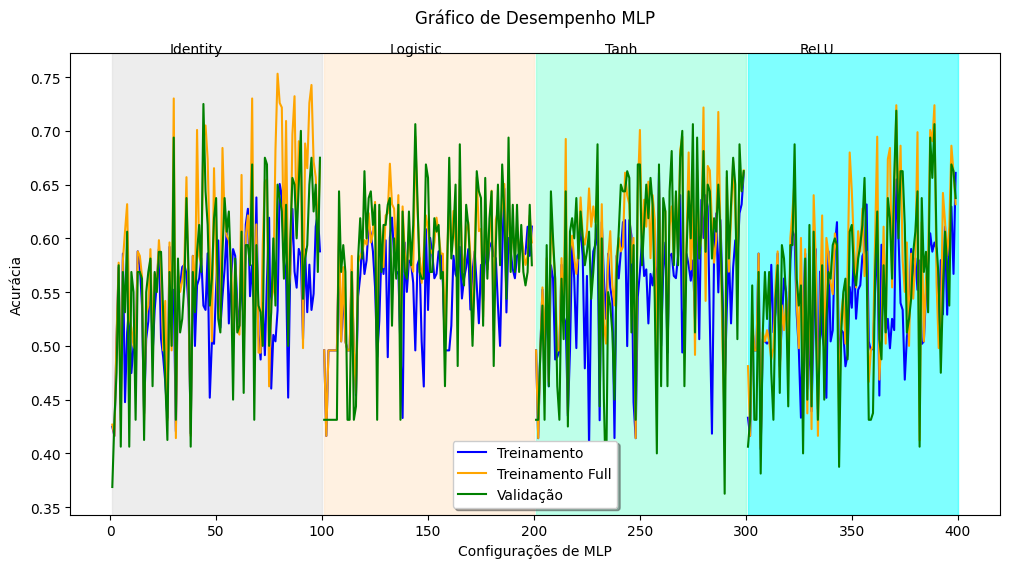

Desempenho da melhor configuração testada:
Ativação: identity
Camadas ocultas: 44
Acurácia de treinamento: 0.6925
Acurácia de validação: 0.7250
Acurácia de teste: 0.6625
Precision: 0.6988
Recall: 0.6667
F1: 0.6824
AUC-ROC: 0.6958


In [ ]:
# Ajustando o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Apresentando todas as configurações testadas
for i, (train, train_full, valid) in enumerate(zip(k_scores_train, k_scores_train_full, k_scores_valid)):
    x = range(i * 100 + 1, (i + 1) * 100)
    plt.plot(x, train, color='blue')
    plt.plot(x, train_full, color='orange')
    plt.plot(x, valid, color='green')

# Cores para os diferentes segmentos de ativação
colors = ['gainsboro', 'bisque', 'aquamarine', 'cyan']
for i, color in enumerate(colors):
    plt.axvspan(i * 100 + 1, (i + 1) * 100, color=color, alpha=0.5)

# Adicionando anotações para as funções de ativação
plt.annotate('Identity', xy=(170, 515), xycoords='figure pixels')
plt.annotate('Logistic', xy=(390, 515), xycoords='figure pixels')
plt.annotate('Tanh', xy=(605, 515), xycoords='figure pixels')
plt.annotate('ReLU', xy=(800, 515), xycoords='figure pixels')

# Ajustes dos eixos e legendas
plt.legend(('Treinamento', 'Treinamento Full', 'Validação'),
           loc='lower center', shadow=True)
plt.xlabel('Configurações de MLP')
plt.ylabel('Acurácia')
plt.title('Gráfico de Desempenho MLP\n')
plt.show()


# Treinar o melhor modelo novamente
best_clf = MLPClassifier(hidden_layer_sizes=(best_k,), activation=best_activation, random_state=10, early_stopping=True, n_iter_no_change=5)
best_clf.fit(X_train, y_train)

# Avaliar o desempenho 
print('Desempenho da melhor configuração testada:')
print(f'Ativação: {best_activation}')
print(f'Camadas ocultas: {best_k}')
print('Acurácia de treinamento: %0.4f' % best_clf.score(X_train, y_train))
print('Acurácia de validação: %0.4f' % best_clf.score(X_valid, y_valid))
print('Acurácia de teste: %0.4f' % best_clf.score(X_test, y_test))
print('Precision: %0.4f' % precision_score(y_test, best_clf.predict(X_test), pos_label=1))
print('Recall: %0.4f' % recall_score(y_test, best_clf.predict(X_test), pos_label=1))
print('F1: %0.4f' % f1_score(y_test, best_clf.predict(X_test), pos_label=1))
print('AUC-ROC: %0.4f' % roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1]))

current_results_rna = {
    "Classificador": "RNA",
    "Ativação": best_activation,
    "Camadas Ocultas": best_k,
    "Acurácia de Treinamento": best_clf.score(X_train, y_train),
    "Acurácia de Validação": best_clf.score(X_valid, y_valid),
    "Acurácia de Teste": best_clf.score(X_test, y_test),
    "Precision": precision_score(y_test, best_clf.predict(X_test), pos_label=1),
    "Recall": recall_score(y_test, best_clf.predict(X_test), pos_label=1),
    "F1": f1_score(y_test, best_clf.predict(X_test), pos_label=1),
    "AUC-ROC": roc_auc_score(y_test, best_clf.predict_proba(X_test)[:, 1])
}

# Adicionar os resultados da RNA à lista de resultados
results.append(current_results_rna)

# Comitê de Redes Neurais Artificiais (Ensemble of Artificial Neural Networks)

O Comitê de Redes Neurais Artificiais é uma abordagem avançada de aprendizado de máquina que combina várias redes neurais para melhorar a precisão e a robustez das previsões. Em vez de depender de um único modelo, essa técnica utiliza múltiplas redes neurais, treinadas de maneira independente, cujas previsões são então agregadas para produzir um resultado final mais confiável. A ideia é que cada rede neural possa capturar diferentes aspectos dos dados e erros individuais dos modelos possam ser compensados pelo desempenho de outros. As combinações podem ser feitas de várias formas, incluindo médias ponderadas, votação majoritária ou métodos mais complexos como stacking, onde um modelo adicional é usado para combinar as previsões das redes neurais. Essa abordagem pode levar a melhorias significativas na performance, especialmente em problemas complexos e com dados ruidosos, mas também pode aumentar a complexidade computacional e a dificuldade de interpretação do modelo.


## Treinando o classificador

## Apresentando os resultados

# Comitê Heterogêneo (Heterogeneous Ensemble)

O Comitê Heterogêneo é uma técnica de aprendizado de máquina que combina diferentes tipos de modelos para aproveitar suas respectivas forças e superar suas fraquezas individuais. Em vez de usar múltiplas instâncias do mesmo tipo de modelo, o comitê heterogêneo agrega previsões de variados algoritmos, como árvores de decisão, máquinas de vetores de suporte e redes neurais, entre outros. Cada modelo contribui com uma perspectiva única sobre os dados, e a combinação das suas previsões pode resultar em um desempenho geral mais robusto e preciso. Os métodos de agregação podem incluir votação majoritária, média ponderada ou métodos de meta-aprendizagem como stacking, onde um modelo adicional aprende a melhor forma de combinar as previsões dos modelos base. Embora a utilização de um comitê heterogêneo possa melhorar significativamente a performance e a robustez, ela também pode aumentar a complexidade do sistema e os requisitos computacionais.


## Treinando o classificador

## Apresentando os resultados

# Comparando os indicadores dos classificadores (resultados)

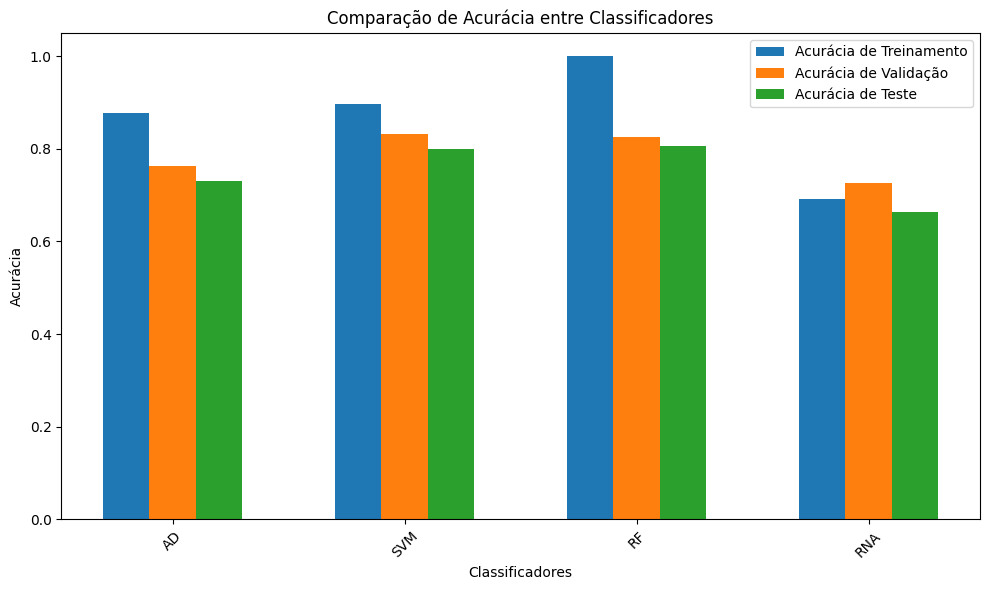

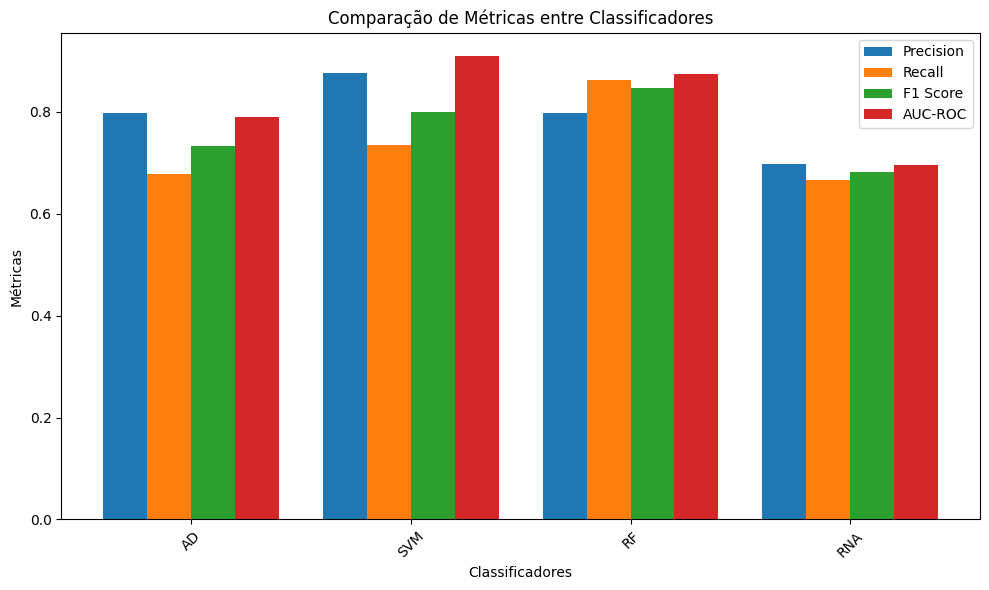

In [ ]:
# Definindo os classificadores e as métricas
classificadores = [result["Classificador"] for result in results]
acuracias_treinamento = [result["Acurácia de Treinamento"] for result in results]
acuracias_validacao = [result["Acurácia de Validação"] for result in results]
acuracias_teste = [result["Acurácia de Teste"] for result in results]
precisions = [result["Precision"] for result in results]
recalls = [result["Recall"] for result in results]
f1_scores = [result["F1"] for result in results]
auc_rocs = [result["AUC-ROC"] for result in results]

# Configurando a posição dos gráficos
x = np.arange(len(classificadores))

# Largura das barras
width = 0.2

# Plotando as acurácias
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, acuracias_treinamento, width, label='Acurácia de Treinamento')
ax.bar(x, acuracias_validacao, width, label='Acurácia de Validação')
ax.bar(x + width, acuracias_teste, width, label='Acurácia de Teste')

# Adicionando labels e título
ax.set_xlabel('Classificadores')
ax.set_ylabel('Acurácia')
ax.set_title('Comparação de Acurácia entre Classificadores')
ax.set_xticks(x)
ax.set_xticklabels(classificadores)
ax.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotando Precision, Recall, F1 e AUC-ROC
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width*1.5, precisions, width, label='Precision')
ax.bar(x - width/2, recalls, width, label='Recall')
ax.bar(x + width/2, f1_scores, width, label='F1 Score')
ax.bar(x + width*1.5, auc_rocs, width, label='AUC-ROC')

# Adicionando labels e título
ax.set_xlabel('Classificadores')
ax.set_ylabel('Métricas')
ax.set_title('Comparação de Métricas entre Classificadores')
ax.set_xticks(x)
ax.set_xticklabels(classificadores)
ax.legend()

# Exibindo o gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Conclusão

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9cbf65cb-016b-458a-bee9-1cc8843984e5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>